In [695]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf

In [696]:
df = pd.read_csv('../seir/cov_datasets/all.csv')
df['Date'] = pd.to_datetime(df['Date'])
print(df.shape)
print(df.dtypes)
df.head()

(555, 4)
Date                     datetime64[ns]
Cummulative_Deaths              float64
Infected                        float64
Cummulative_Recovered           float64
dtype: object


,Date,Cummulative_Deaths,Infected,Cummulative_Recovered
0,2020-02-14,1.0,5.0,12.0
1,2020-02-15,1.0,4.0,12.0
2,2020-02-16,1.0,1.0,13.0
3,2020-02-17,1.0,6.0,12.0
4,2020-02-18,1.0,8.0,14.0


In [743]:
df[500:]

,Cummulative_Deaths,Infected,Cummulative_Recovered
Date,,,
2021-06-28,14700.0,989.0,761879.0
2021-06-29,14735.0,1376.0,763569.0
2021-06-30,14776.0,1810.0,765277.0
2021-07-01,14797.0,1741.0,766949.0
2021-07-02,14819.0,1773.0,768722.0
2021-07-03,14837.0,1864.0,770414.0
2021-07-04,14843.0,1479.0,771975.0
2021-07-05,14857.0,1021.0,773568.0
2021-07-06,14879.0,1658.0,775406.0


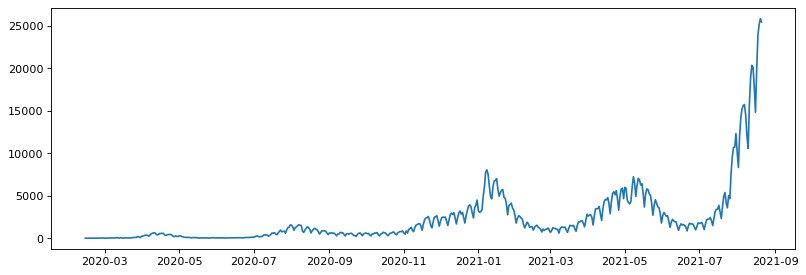

In [697]:
from matplotlib.pyplot import figure
figure(figsize=(12, 4), dpi=80)
plt.plot(df['Date'],df['Infected'])
plt.show()

In [698]:
training_set = df.iloc[:500, 2:3].values.astype(int)
test_set = df.iloc[500:, 2:3].values.astype(int)

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.fit_transform(test_set)


# Creating a data structure with 5 time-steps and 2 output
X_train = []
y_train = []

X_test = []
y_test = []
steps = 5 #days

In [699]:
print(training_set_scaled.shape)
print(testing_set_scaled.shape)

(500, 1)
(55, 1)


In [700]:
def split_seq(sequence, n_steps_in, n_steps_out):
    X = []
    y = []
    for i in range(len(sequence)):
        end_idx = i + n_steps_in
        steps_out_idx = end_idx + n_steps_out
        
        #check if we reach end of arr or not
        if (steps_out_idx > len(sequence)):
            break
        seq_x = sequence[i:end_idx]
        seq_y = sequence[end_idx:steps_out_idx]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [701]:
X_train , y_train = split_seq(training_set_scaled, 14,1)
X_test , y_test = split_seq(testing_set_scaled, 14,1)

In [702]:
y_test

array([[[0.02018577]],

       [[0.05581246]],

       [[0.08769955]],

       [[0.09726969]],

       [[0.09771201]],

       [[0.11588725]],

       [[0.08460332]],

       [[0.05344003]],

       [[0.11074028]],

       [[0.15859102]],

       [[0.17680647]],

       [[0.12927741]],

       [[0.10402509]],

       [[0.16160682]],

       [[0.14757328]],

       [[0.26659697]],

       [[0.34496763]],

       [[0.38996341]],

       [[0.39161205]],

       [[0.45594917]],

       [[0.36877237]],

       [[0.29494551]],

       [[0.44521292]],

       [[0.53138445]],

       [[0.57332422]],

       [[0.58848365]],

       [[0.5931481 ]],

       [[0.54155776]],

       [[0.44489123]],

       [[0.38509791]],

       [[0.59431421]],

       [[0.71993245]],

       [[0.77880092]],

       [[0.76975351]],

       [[0.67702762]],

       [[0.55639551]],

       [[0.76235474]],

       [[0.92162934]],

       [[0.97128956]],

       [[1.        ]],

       [[0.98403635]]])

In [703]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(486, 14, 1) (486, 1, 1)
(41, 14, 1) (41, 1, 1)


In [704]:
input_shape = (X_train.shape[1],X_train.shape[2])
input_shape

(14, 1)

In [705]:
model = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
16/16 [==============================] - 0s 17ms/step - loss: 0.0344
Epoch 2/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0173
Epoch 3/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0167
Epoch 4/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0116
Epoch 5/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0125
Epoch 6/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0108
Epoch 7/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0120
Epoch 8/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0125
Epoch 9/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0097
Epoch 10/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0110
Epoch 11/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0107
Epoch 12/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0092
Epoch 13/50
16/16 [==================

In [706]:
y_pred = model.predict(X_test)
y_pred = sc.inverse_transform(y_pred) #revert scaling

In [707]:
print(y_pred.shape)
y_pred = y_pred.reshape(41)
print(y_pred)

(41, 1)
[ 1967.5939  2052.4905  2144.919   2271.373   2422.5845  2631.1199
  2912.3054  3188.3577  3381.7207  3568.1086  3773.8875  4020.4053
  4301.9863  4568.4927  4754.5425  4857.541   5098.7334  5612.994
  6465.246   7630.6973  9067.51   10449.382  11484.035  12239.141
 12774.059  13206.16   13610.28   14098.468  14685.9375 15053.421
 15125.069  14900.711  14640.211  14656.9795 15204.301  16001.616
 16718.99   17469.127  18195.7    18963.37   19846.715 ]


In [708]:
#y_test = y_test.reshape(41)
y_test = sc.inverse_transform(y_test.reshape(41,1)).reshape(41) #revert scaling
print(y_test)

[ 1491.  2377.  3170.  3408.  3419.  3871.  3093.  2318.  3743.  4933.
  5386.  4204.  3576.  5008.  4659.  7619.  9568. 10687. 10728. 12328.
 10160.  8324. 12061. 14204. 15247. 15624. 15740. 14457. 12053. 10566.
 15769. 18893. 20357. 20132. 17826. 14826. 19948. 23909. 25144. 25858.
 25461.]


In [709]:
for i in y_pred:
    print(i)

1967.5939
2052.4905
2144.919
2271.373
2422.5845
2631.1199
2912.3054
3188.3577
3381.7207
3568.1086
3773.8875
4020.4053
4301.9863
4568.4927
4754.5425
4857.541
5098.7334
5612.994
6465.246
7630.6973
9067.51
10449.382
11484.035
12239.141
12774.059
13206.16
13610.28
14098.468
14685.9375
15053.421
15125.069
14900.711
14640.211
14656.9795
15204.301
16001.616
16718.99
17469.127
18195.7
18963.37
19846.715


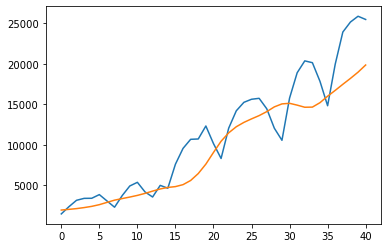

In [710]:
plt.plot(y_test)
plt.plot(y_pred)

### Adding news

In [711]:
df_news = pd.read_csv('../nlp/Aug30th_all_articles_bin_graded.csv')
df_news['news_written_date'] = pd.to_datetime(df_news['news_written_date'])
df_news['news_written_date'] = df_news['news_written_date'].dt.date
print(df_news.shape)
print(df_news.dtypes)
df_news.tail()

(1329, 6)
binary_score (1:good   0: bad)    float64
news_title                         object
news_writer                        object
news_written_date                  object
news_text                          object
news_url                           object
dtype: object


C:\Users\maidu\.conda\envs\tf\lib\site-packages\dateutil\parser\_parser.py:1213: UnknownTimezoneWarning: tzname JST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


,binary_score (1:good 0: bad),news_title,news_writer,news_written_date,news_text,news_url
1324,0.0,COVID-19 cases (Aug. 31),['THE ASAHI SHIMBUN'],2020-09-01,NaN,https://www.asahi.com//ajw/articles/13686785
1325,0.0,Tokyo confirms 100 new cases of COVID-19; seve...,['THE ASAHI SHIMBUN'],2020-08-31,Tokyo confirmed 100 new COVID-19 infections o...,https://www.asahi.com//ajw/articles/13684411
1326,0.0,Tokyo partners with Line for new COVID-19 chec...,['By RIHITO KARUBE/ Staff Writer'],2020-08-31,Health centers in Tokyo will soon have a new ...,https://www.asahi.com//ajw/articles/13684298
1327,0.0,COVID-19 cases (Aug. 30),['THE ASAHI SHIMBUN'],2020-08-31,NaN,https://www.asahi.com//ajw/articles/13683645
1328,1.0,"Japanese wear face masks, but the main reason ...",['By MASANORI KOBAYASHI/ Staff Writer'],2020-08-31,Japanese people have taken to wearing face ma...,https://www.asahi.com//ajw/articles/13655141


In [712]:
#run once only

df = df.set_index('Date') #Infected list
print(df.shape, df_news.shape)
df_news = df_news.set_index('news_written_date')


(555, 3) (1329, 6)


#### Merge df and df_news

In [713]:

df_merged = pd.merge(df,df_news, how='inner', left_index=True, right_index=True)
df_merged

,Cummulative_Deaths,Infected,Cummulative_Recovered,binary_score (1:good 0: bad),news_title,news_writer,news_text,news_url
2020-08-31,1295.0,430.0,57130.0,0.0,Tokyo confirms 100 new cases of COVID-19; seve...,['THE ASAHI SHIMBUN'],Tokyo confirmed 100 new COVID-19 infections o...,https://www.asahi.com//ajw/articles/13684411
2020-08-31,1295.0,430.0,57130.0,0.0,Tokyo partners with Line for new COVID-19 chec...,['By RIHITO KARUBE/ Staff Writer'],Health centers in Tokyo will soon have a new ...,https://www.asahi.com//ajw/articles/13684298
2020-08-31,1295.0,430.0,57130.0,0.0,COVID-19 cases (Aug. 30),['THE ASAHI SHIMBUN'],NaN,https://www.asahi.com//ajw/articles/13683645
2020-08-31,1295.0,430.0,57130.0,1.0,"Japanese wear face masks, but the main reason ...",['By MASANORI KOBAYASHI/ Staff Writer'],Japanese people have taken to wearing face ma...,https://www.asahi.com//ajw/articles/13655141
2020-09-01,1306.0,624.0,57735.0,0.0,Tokyo reports 2nd case of virus infections in ...,['THE ASAHI SHIMBUN'],While Tokyo recorded less than 200 new COVID-...,https://www.asahi.com//ajw/articles/13687614
...,...,...,...,...,...,...,...,...
2021-08-20,15556.0,25858.0,1033914.0,0.0,"New guidelines eyed for issuing, ending state ...",['By KEISHI NISHIMURA/ Staff Writer'],The government is considering changing its gu...,https://www.asahi.com//ajw/articles/14421871
2021-08-20,15556.0,25858.0,1033914.0,0.0,COVID-19 cases (Aug. 19),['THE ASAHI SHIMBUN'],NaN,https://www.asahi.com//ajw/articles/14421857
2021-08-20,15556.0,25858.0,1033914.0,0.0,Kyoto eateries whip up industry certification ...,['By RIKAKO TAKAI/ Staff Writer'],"KYOTO--In the age of the novel coronavirus, h...",https://www.asahi.com//ajw/articles/14413954
2021-08-21,15589.0,25461.0,1048617.0,0.0,"COVID-19 cases in Tokyo top 5,000; records in ...",['THE ASAHI SHIMBUN'],"Tokyo confirmed 5,074 fresh cases of COVID-19...",https://www.asahi.com//ajw/articles/14422889


In [714]:
df_merged.columns

Index(['Cummulative_Deaths', 'Infected', 'Cummulative_Recovered',
       'binary_score (1:good   0: bad)', 'news_title', 'news_writer',
       'news_text', 'news_url'],
      dtype='object')

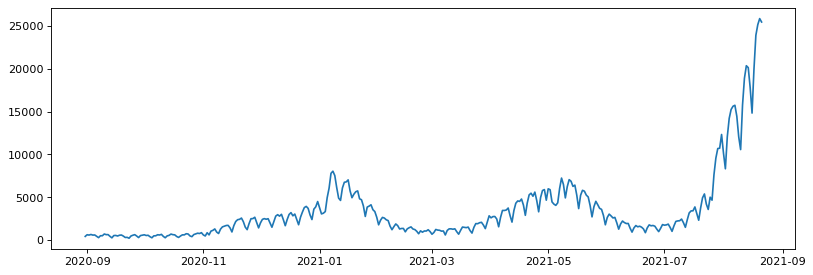

In [715]:
from matplotlib.pyplot import figure
figure(figsize=(12, 4), dpi=80)
plt.plot(df_merged['Infected'])

In [716]:
df_inf_news = df_merged[['Infected','binary_score (1:good   0: bad)']]
df_inf_news

,Infected,binary_score (1:good 0: bad)
2020-08-31,430.0,0.0
2020-08-31,430.0,0.0
2020-08-31,430.0,0.0
2020-08-31,430.0,1.0
2020-09-01,624.0,0.0
...,...,...
2021-08-20,25858.0,0.0
2021-08-20,25858.0,0.0
2021-08-20,25858.0,0.0
2021-08-21,25461.0,0.0


In [717]:
import random
for idx, row in df_inf_news.iterrows():
    #print(row['binary_score (1:good   0: bad)'])
    ele = row['binary_score (1:good   0: bad)']
    if(ele == 0):
        row['binary_score (1:good   0: bad)'] = random.randrange(-4,1) #-4 to 0
    else: 
        row['binary_score (1:good   0: bad)'] = random.randrange(1, 5)

(array([208., 216., 228., 200.,   0., 220.,  56.,  56.,  57.,  59.]),
 array([-4. , -3.2, -2.4, -1.6, -0.8,  0. ,  0.8,  1.6,  2.4,  3.2,  4. ]),
 <BarContainer object of 10 artists>)

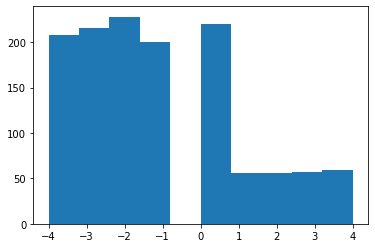

In [718]:
plt.hist(df_inf_news['binary_score (1:good   0: bad)'])

In [719]:
df_inf_news.to_csv('df_infected_news_decimal.csv')

#### Only scale binary score

In [720]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
infected_scaled = sc.fit_transform(df_inf_news['Infected'].values.astype(float).reshape(len(df_inf_news), 1))
score_scaled = sc.fit_transform(df_inf_news['binary_score (1:good   0: bad)'].values.astype(float).reshape(len(df_inf_news), 1))

df_inf_news['infected_scaled'] = infected_scaled[:,0]
df_inf_news['score_scaled'] = score_scaled[:,0]/100

df_inf_news.head()

<ipython-input-720-b58dc20c5b37>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inf_news['infected_scaled'] = infected_scaled[:,0]
<ipython-input-720-b58dc20c5b37>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inf_news['score_scaled'] = score_scaled[:,0]/100


,Infected,binary_score (1:good 0: bad),infected_scaled,score_scaled
2020-08-31,430.0,-3.0,0.008346,0.00125
2020-08-31,430.0,-3.0,0.008346,0.00125
2020-08-31,430.0,-1.0,0.008346,0.00375
2020-08-31,430.0,1.0,0.008346,0.00625
2020-09-01,624.0,-1.0,0.015911,0.00375


In [721]:
def split_seq(sequence, n_steps_in, n_steps_out):
    X = []
    y = []
    for i in range(len(sequence)):
        end_idx = i + n_steps_in
        steps_out_idx = end_idx + n_steps_out
        
        #check if we reach end of arr or not
        if (steps_out_idx > len(sequence)):
            break
        seq_x = sequence[i:end_idx]
        seq_y = sequence[end_idx:steps_out_idx]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [722]:
X_infected, y_infected = split_seq(df_inf_news['infected_scaled'],4,1)
#print(X_infected.shape, y_infected.shape)
X_news, y_news = split_seq(df_inf_news['score_scaled'],4,1)
#print(X_news.shape, y_news.shape)

### Concat horizotally with hstack
X = np.hstack([X_infected,X_news])
#X = np.hstack([X_infected])

y = np.hstack([y_infected]) #only output infected cases

X = X.reshape((X.shape[0],X.shape[1],1))
y = y.reshape((y.shape[0],y.shape[1],1))

print(X.shape)
print(y.shape)

(1296, 8, 1)
(1296, 1, 1)


In [723]:
y

array([[[0.0159114 ]],

       [[0.0159114 ]],

       [[0.01439045]],

       ...,

       [[1.        ]],

       [[0.98451759]],

       [[0.98451759]]])

In [724]:
X_train = X[:1000,:]
X_test  = X[1000:,:]
y_train = y[:1000,:]
y_test  = y[1000:,:]

In [725]:
input_shape = (X_train.shape[1],X_train.shape[2])
input_shape

(8, 1)

In [726]:
model = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, activation='relu', input_shape = input_shape))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True,activation='relu'))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, activation='relu'))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, activation='relu'))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1, activation='relu'))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 50, batch_size = 128)

Epoch 1/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0139
Epoch 2/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0077
Epoch 3/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0066
Epoch 4/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0060
Epoch 5/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0056
Epoch 6/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0050
Epoch 7/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0036
Epoch 8/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0018
Epoch 9/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0014
Epoch 10/50
8/8 [==============================] - 0s 18ms/step - loss: 8.7650e-04
Epoch 11/50
8/8 [==============================] - 0s 18ms/step - loss: 8.5090e-04
Epoch 12/50
8/8 [==============================] - 0s 22ms/step - loss: 8.5164e-04
Epoch 13/50
8/8 [==============================] 

In [727]:
y_pred = model.predict(X_test)
#y_pred = sc.inverse_transform(y_pred) #revert scaling

In [728]:
y_pred.shape

(296, 1)

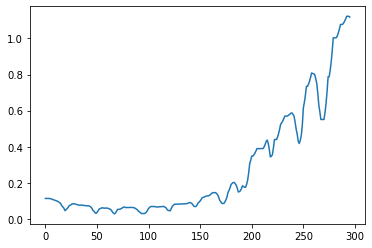

In [729]:
plt.plot(y_pred)
plt.show()

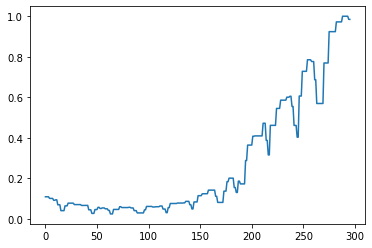

In [730]:
plt.plot(y_test.reshape(len(y_test)))

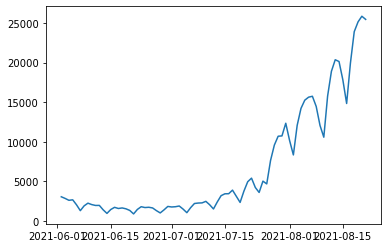

In [731]:
plt.plot(df_merged['Infected'][1000:])

In [732]:
# univariate multi-step vector-output stacked lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# choose a number of time steps
n_steps_in, n_steps_out = 3, 2

# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(X, y, epochs=50, verbose=0)
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[123.46404 141.79414]]


In [733]:
X.shape

(5, 3, 1)

In [734]:
X

array([[[10],
        [20],
        [30]],

       [[20],
        [30],
        [40]],

       [[30],
        [40],
        [50]],

       [[40],
        [50],
        [60]],

       [[50],
        [60],
        [70]]])

In [735]:
y

array([[40, 50],
       [50, 60],
       [60, 70],
       [70, 80],
       [80, 90]])

In [736]:

# multivariate multi-step stacked lstm example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])

# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))

# choose a number of time steps
n_steps_in, n_steps_out = 3, 2

# covert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)

# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(X, y, epochs=200, verbose=0)

# demonstrate prediction
x_input = array([[70, 75], [80, 85], [90, 95]])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)

print(yhat)

[[186.81908 207.46407]]


In [737]:
X

array([[[10, 15],
        [20, 25],
        [30, 35]],

       [[20, 25],
        [30, 35],
        [40, 45]],

       [[30, 35],
        [40, 45],
        [50, 55]],

       [[40, 45],
        [50, 55],
        [60, 65]],

       [[50, 55],
        [60, 65],
        [70, 75]],

       [[60, 65],
        [70, 75],
        [80, 85]]])

In [738]:
dataset

array([[ 10,  15,  25],
       [ 20,  25,  45],
       [ 30,  35,  65],
       [ 40,  45,  85],
       [ 50,  55, 105],
       [ 60,  65, 125],
       [ 70,  75, 145],
       [ 80,  85, 165],
       [ 90,  95, 185]])

In [739]:
y

array([[ 65,  85],
       [ 85, 105],
       [105, 125],
       [125, 145],
       [145, 165],
       [165, 185]])

In [740]:
from numpy import array
data = array([
	[0.1, 1.0],
	[0.2, 0.9],
	[0.3, 0.8],
	[0.4, 0.7],
	[0.5, 0.6],
	[0.6, 0.5],
	[0.7, 0.4],
	[0.8, 0.3],
	[0.9, 0.2],
	[1.0, 0.1]])
data = data.reshape(1, 10, 2)
print(data.shape)

(1, 10, 2)


In [741]:
data

array([[[0.1, 1. ],
        [0.2, 0.9],
        [0.3, 0.8],
        [0.4, 0.7],
        [0.5, 0.6],
        [0.6, 0.5],
        [0.7, 0.4],
        [0.8, 0.3],
        [0.9, 0.2],
        [1. , 0.1]]])

In [742]:
# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])

# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
dataset

array([[ 10,  15,  25],
       [ 20,  25,  45],
       [ 30,  35,  65],
       [ 40,  45,  85],
       [ 50,  55, 105],
       [ 60,  65, 125],
       [ 70,  75, 145],
       [ 80,  85, 165],
       [ 90,  95, 185]])